In [1]:
#https://www.kaggle.com/adityapachpande/spaceship-titanic-ml-gradientboosting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
df_train = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Columns Description**
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [3]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [4]:
df_test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


In [5]:
df_train.set_index('PassengerId',inplace=True)
df_test.set_index('PassengerId',inplace=True)

In [6]:
df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)
df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)

df_train['Age'] =df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] =df_test['Age'].fillna(df_test['Age'].median())

df_train['VIP'] =df_train['VIP'].fillna(False)
df_test['VIP'] =df_test['VIP'].fillna(False)

df_train['HomePlanet'] =df_train['HomePlanet'].fillna('Mars')
df_test['HomePlanet'] =df_test['HomePlanet'].fillna('Mars')

df_train['Destination']=df_train['Destination'].fillna("PSO J318.5-22")
df_test['Destination']=df_test['Destination'].fillna("PSO J318.5-22")

df_train['CryoSleep'] =df_train['CryoSleep'].fillna(False)
df_test['CryoSleep'] =df_test['CryoSleep'].fillna(False)

df_train['Cabin'] =df_train['Cabin'].fillna('T/0/P')
df_test['Cabin'] =df_test['Cabin'].fillna('T/0/P')



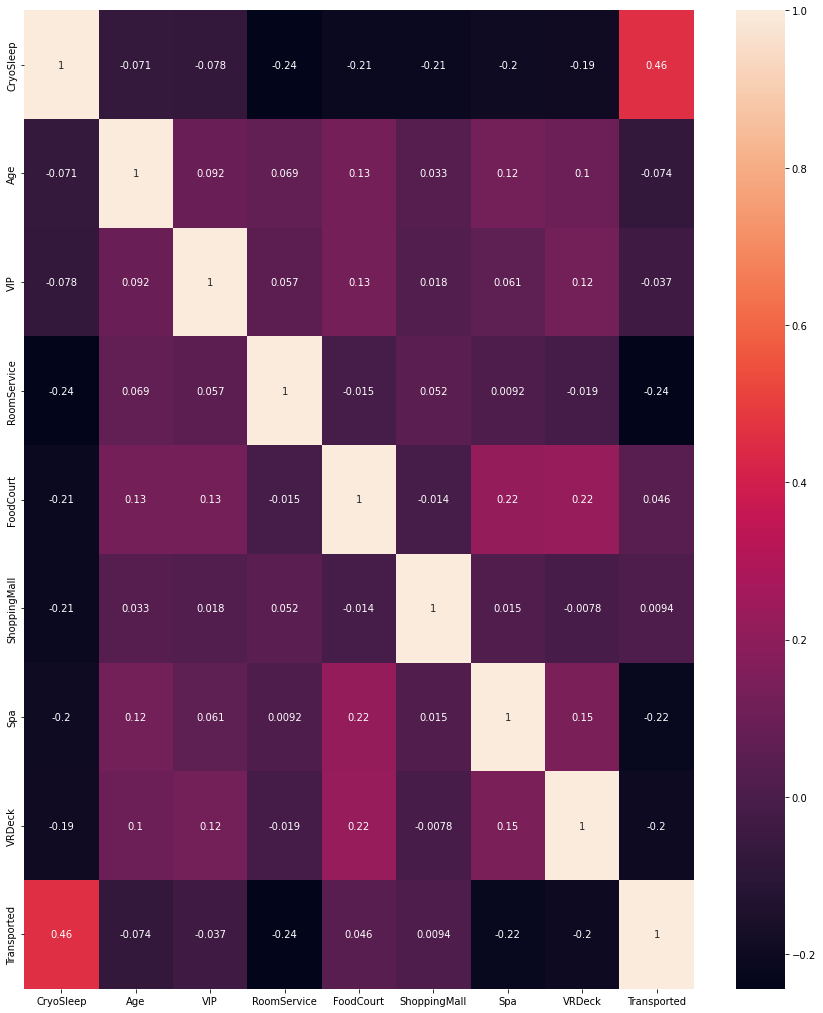

In [7]:
plt.figure(figsize=(15,18))
sns.heatmap(df_train.corr(), annot=True);

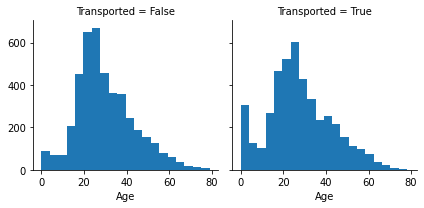

In [8]:
g = sns.FacetGrid(df_train, col='Transported')
g.map(plt.hist, 'Age', bins=20)

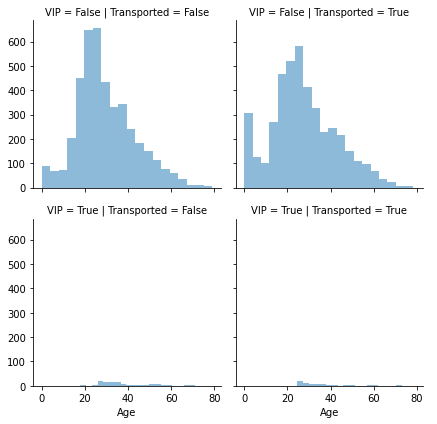

In [9]:
VIPgrid = sns.FacetGrid(df_train, col = 'Transported', row = "VIP")
VIPgrid.map(plt.hist, 'Age', alpha =.5, bins = 20)
VIPgrid.add_legend();

Text(0.5, 0, 'Age (years)')

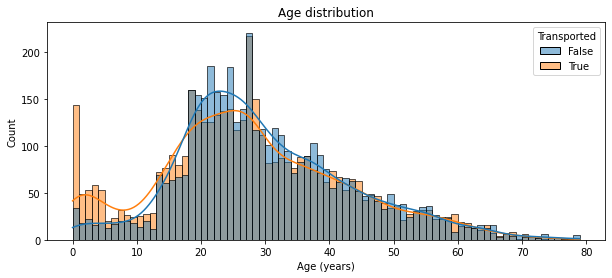

In [10]:
plt.figure(figsize=(10,4))
sns.histplot(data=df_train, x='Age', hue='Transported', binwidth=1, kde=True)

plt.title('Age distribution')
plt.xlabel('Age (years)')

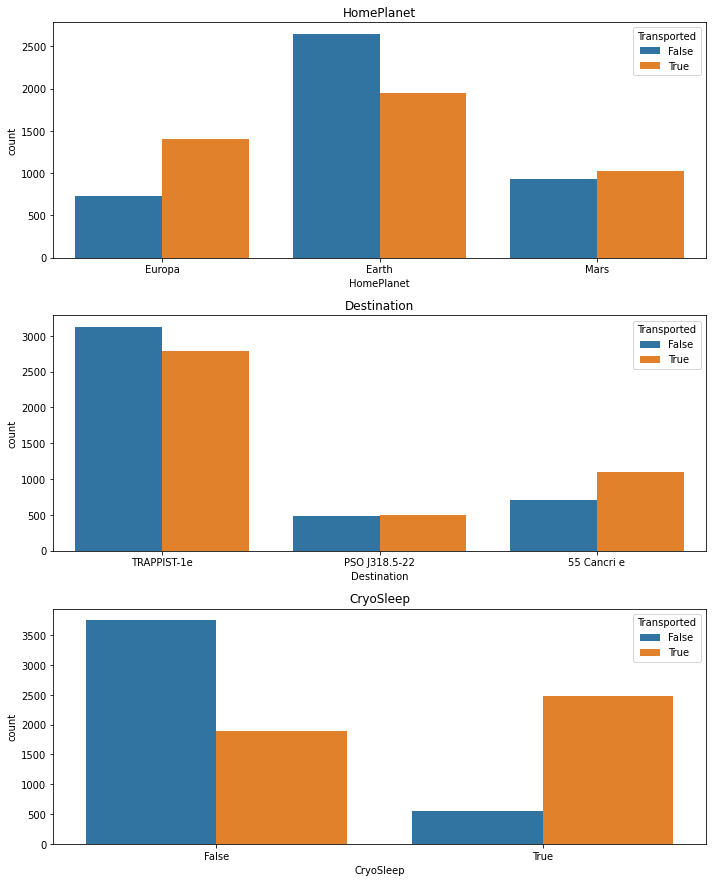

In [11]:
feats=['HomePlanet','Destination','CryoSleep']
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=df_train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()

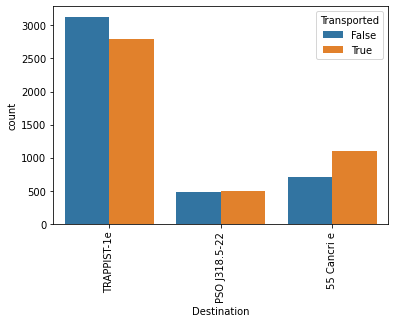

In [12]:
sns.countplot(df_train.Destination,hue=df_train.Transported)
plt.xticks(rotation=90);

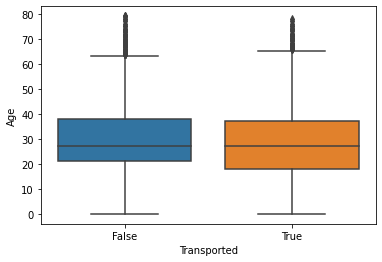

In [13]:
sns.boxplot(y=df_train.Age,x=df_train.Transported);

In [14]:
df_train[['Deck','Num','Side']] = df_train.Cabin.str.split('/',expand=True)
df_test[['Deck','Num','Side']] = df_test.Cabin.str.split('/',expand=True)

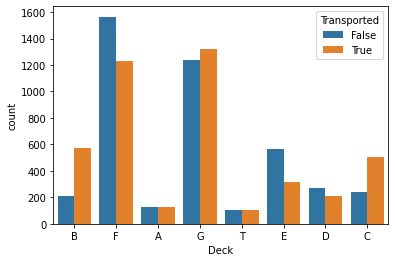

In [15]:
sns.countplot(df_train.Deck,hue=df_train.Transported);

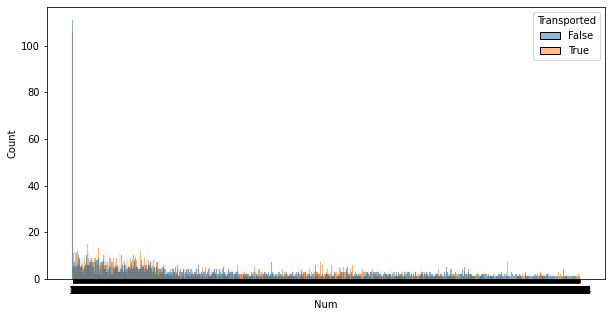

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(data=df_train, x='Num', hue='Transported',bins=14);

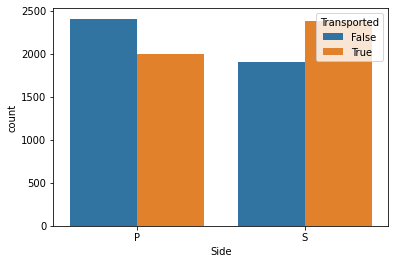

In [17]:
sns.countplot(df_train.Side,hue=df_train.Transported);

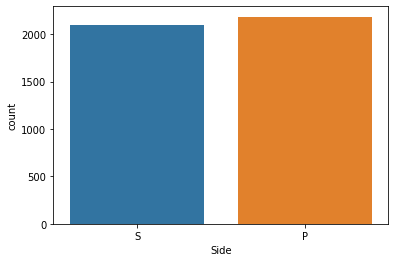

In [18]:
sns.countplot(df_test.Side);

In [19]:
df_train['total_spent']= df_train['RoomService']+ df_train['FoodCourt']+ df_train['ShoppingMall']+ df_train['Spa']+ df_train['VRDeck']
df_test['total_spent']=df_test['RoomService']+df_test['FoodCourt']+df_test['ShoppingMall']+df_test['Spa']+df_test['VRDeck']

In [20]:
df_train['AgeGroup'] = 0
for i in range(6):
    df_train.loc[(df_train.Age >= 10*i) & (df_train.Age < 10*(i + 1)), 'AgeGroup'] = i

df_test['AgeGroup'] = 0
for i in range(6):
    df_test.loc[(df_test.Age >= 10*i) & (df_test.Age < 10*(i + 1)), 'AgeGroup'] = i

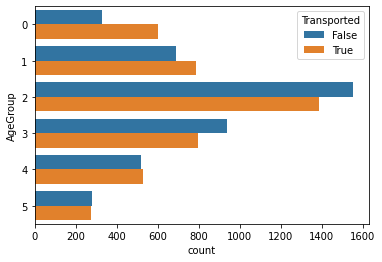

In [21]:
sns.countplot(y=df_train['AgeGroup'],hue=df_train['Transported']);

In [22]:
from sklearn.preprocessing import LabelEncoder

categorical_cols= ['HomePlanet','CryoSleep','Destination','VIP','Deck','Side','Num']
for i in categorical_cols:
    print(i)
    le=LabelEncoder()
    arr=np.concatenate((df_train[i], df_test[i])).astype(str)
    le.fit(arr)
    df_train[i]=le.transform(df_train[i].astype(str))
    df_test[i]=le.transform(df_test[i].astype(str))

HomePlanet
CryoSleep
Destination
VIP
Deck
Side
Num


In [23]:
df_train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Num,Side,total_spent,AgeGroup
PassengerId,,,,,,,,,,,,,,,,,,
0001_01,1,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,0,0,0.0,3
0002_01,0,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,5,0,1,736.0,2
0003_01,1,0,A/0/S,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0,0,1,10383.0,5
0003_02,1,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0,0,1,5176.0,3
0004_01,0,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,5,1,1,1091.0,1


In [24]:
df_train= df_train.drop(['Name','Cabin'],axis=1)
df_test= df_test.drop(['Name','Cabin'],axis=1)

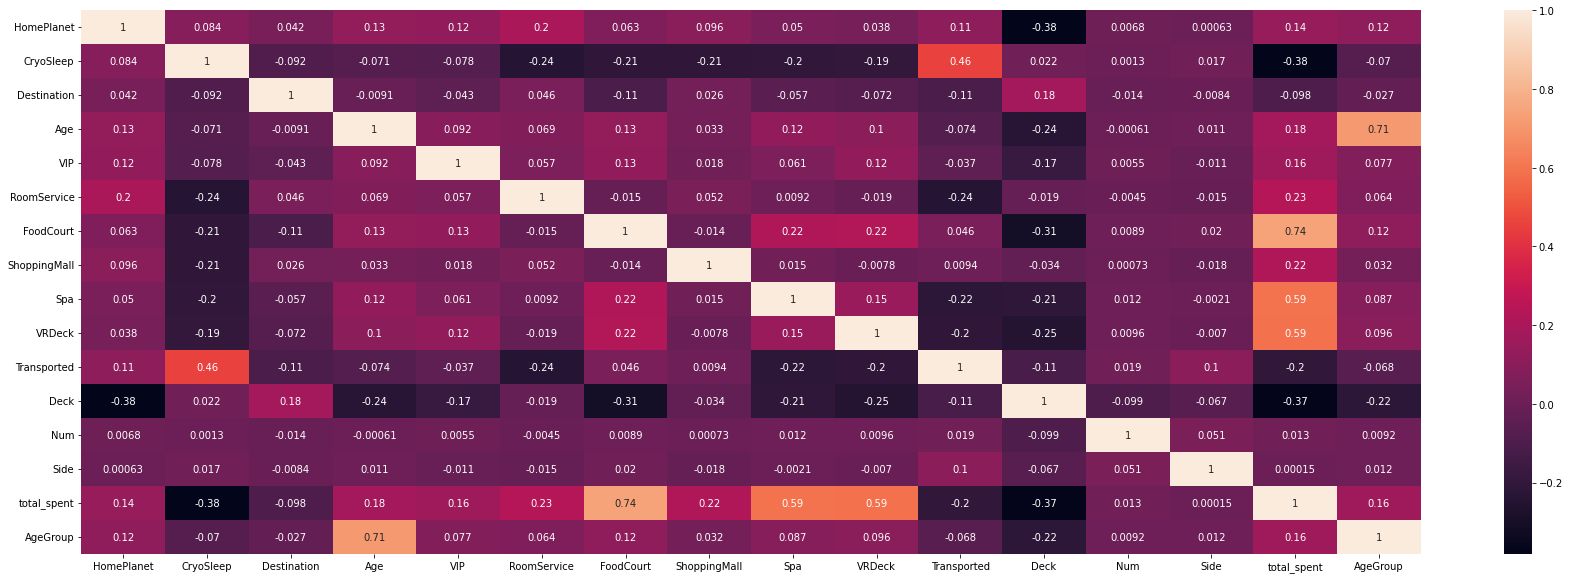

In [25]:
plt.figure(figsize=(30,10))
sns.heatmap(df_train.corr(), annot=True);

In [26]:
df_train['Transported']=df_train['Transported'].replace({True:1,False:0})

In [27]:
X=df_train.drop('Transported',axis=1)
y = df_train['Transported']

In [28]:
X.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Deck', 'Num', 'Side',
       'total_spent', 'AgeGroup'],
      dtype='object')

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=0)

# Modeling

In [30]:
from catboost import CatBoostClassifier
model=CatBoostClassifier(iterations=1500,
                         eval_metric='Accuracy',
                        verbose=0)

In [31]:
model.fit(X_train,y_train)

In [32]:
pred_y=model.predict(X_val)

pred=model.predict(X_train)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_val.values,pred_y))

0.8792759625709464
0.8104875804967802


In [33]:
from sklearn.model_selection import GridSearchCV
gcv=GridSearchCV(CatBoostClassifier(),param_grid={'iterations': range(200,2000,200), 'eval_metric': ['Accuracy'],'verbose':[0]},cv=3)
gcv.fit(X_train,y_train)
pred_y=gcv.predict(X_val)

pred=gcv.predict(X_train)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_val.values,pred_y))

0.8794293603313391
0.812327506899724


In [34]:
from sklearn.ensemble import GradientBoostingClassifier
gb=GradientBoostingClassifier(random_state=1,n_estimators=250,learning_rate=0.15,max_depth=3)
gb.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.15, n_estimators=250, random_state=1)

In [35]:
pred_y=gb.predict(X_val)
pred=gb.predict(X_train)
    
print(accuracy_score(y_train.values,pred))
print(accuracy_score(y_val.values,pred_y))

0.8665439484583525
0.8031278748850046


In [ ]:
gcv.fit(X,y)

In [ ]:
y_pred = gcv.predict(df_test)

sub=pd.DataFrame({'Transported':y_pred.astype(bool)},index=df_test.index)

sub.head()